In [5]:
#Importacion de librerias
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

## Ecuacion Diferencial Lineal de Primer Orden:
$$ y'(x)+y(x)=0 \hspace{1cm} 0 \leqslant x \leqslant 4 $$ 

### Condiciones Iniciales:
$$ y(0)=1 $$

### Solución Analítica:
$$ y(x) = e^{-x} $$


In [6]:
# Definimos una clase llamada ODE_1st, que extiende el modelo de TensorFlow
# Esta clase está diseñada para resolver una EDO de primer orden utilizando redes neuronales PINN
class ODE_1st(tf.keras.Model):
    def train_step(self, data):
        # Los puntos de entrenamiento y su solución exacta en esos puntos
        x, y_exact = data
        # Condiciones iniciales para la red PINN
        x0 = tf.constant([0.0], dtype=tf.float32)  # Punto inicial x = 0
        y0_exact = tf.constant([1.0], dtype=tf.float32)  # Condición inicial: y(0) = 1

        # Calculamos los gradientes y actualizamos los pesos de la red
        with tf.GradientTape() as tape:
            # Calculamos la derivada dy/dx utilizando otra cinta de gradiente (tape2)
            with tf.GradientTape() as tape2:
                tape2.watch(x0)  # Observa el valor inicial x0
                tape2.watch(x)  # Observa los valores de x en los puntos de entrenamiento
                y0_NN = self(x0, training=True)  # Salida de la red en el punto x0
                y_NN = self(x, training=True)  # Salida de la red en los puntos de entrenamiento x
            dy_dx_NN = tape2.gradient(y_NN, x)  # Calculamos dy/dx en x usando diferenciación automática

            # La función de pérdida incluye el error en la ecuación diferencial
            # y en las condiciones de frontera/iniciales
            # Para la EDO: y'(x) + y(x) = 0
            loss = self.compiled_loss(dy_dx_NN, -y_NN) + self.compiled_loss(y0_NN, y0_exact)

        # Calculamos los gradientes de la pérdida respecto a los pesos entrenables
        gradients = tape.gradient(loss, self.trainable_weights)
        # Aplicamos los gradientes a los pesos del modelo usando el optimizador
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        
        # Actualizamos los valores de las métricas con la solución exacta y la predicción de la red
        self.compiled_metrics.update_state(y_exact, y_NN)
        
        # Devolvemos las métricas calculadas (p.e., el error cuadrático medio)
        return {m.name: m.result() for m in self.metrics}

In [7]:
# Definición de los datos de entrenamiento
n_train = 20  # Número de puntos de entrenamiento
xmin = 0  # Límite inferior del dominio
xmax = 4  # Límite superior del dominio
x_train = np.linspace(xmin, xmax, n_train)  # Puntos de entrenamiento equiespaciados entre 0 y 4

# Solución exacta de y(x) en los puntos de entrenamiento para evaluar el modelo
y_train = tf.exp(-x_train)  # La solución exacta para y' + y = 0 es y = e^(-x)

# Definimos los hiperparámetros de la red neuronal
input_neurons = 1  # Número de neuronas de entrada
output_neurons = 1  # Número de neuronas de salida
epochs = 40  # Número de épocas de entrenamiento

# Definimos la arquitectura de la red neuronal
activation = 'elu'  # Función de activación
input = Input(shape=(input_neurons,))  # Capa de entrada
x = Dense(50, activation=activation)(input)  # Capa oculta con 50 neuronas
x = Dense(50, activation=activation)(x)  # Segunda capa oculta con 50 neuronas
x = Dense(50, activation=activation)(x)  # Tercera capa oculta con 50 neuronas
output = Dense(output_neurons, activation=None)(x)  # Capa de salida sin activación
model = ODE_1st(input, output)  # Definimos el modelo como una instancia de ODE_1st

# Definición de la función de pérdida, métrica y optimizador
loss = tf.keras.losses.MeanSquaredError()  # Error cuadrático medio como pérdida
metrics = tf.keras.metrics.MeanSquaredError()  # Error cuadrático medio como métrica
optimizer = Adam(learning_rate=0.001)  # Optimizador Adam con tasa de aprendizaje 0.001

# Compilación del modelo con la pérdida, optimizador y métrica definida
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
model.summary()  # Resumen de la arquitectura del modelo

# Entrenamiento del modelo en los datos de entrenamiento (x_train, y_train)
history = model.fit(x_train, y_train, batch_size=1, epochs=epochs)

Model: "ode_1st_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - mean_squared_error: 0.1399 - loss: 0.0521    
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0150 - loss: 0.2401 
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0141 - loss: 0.2848 
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0019 - loss: 0.2646     
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0165 - loss: 0.3712     
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0062 - loss: 0.2875     
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0022 - loss: 0.2543 
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0011 - loss: 0.2319     
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0022 - loss: 0.1777 
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0039 - loss: 0.3292 
Epoch 11/40
20/20 ━━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


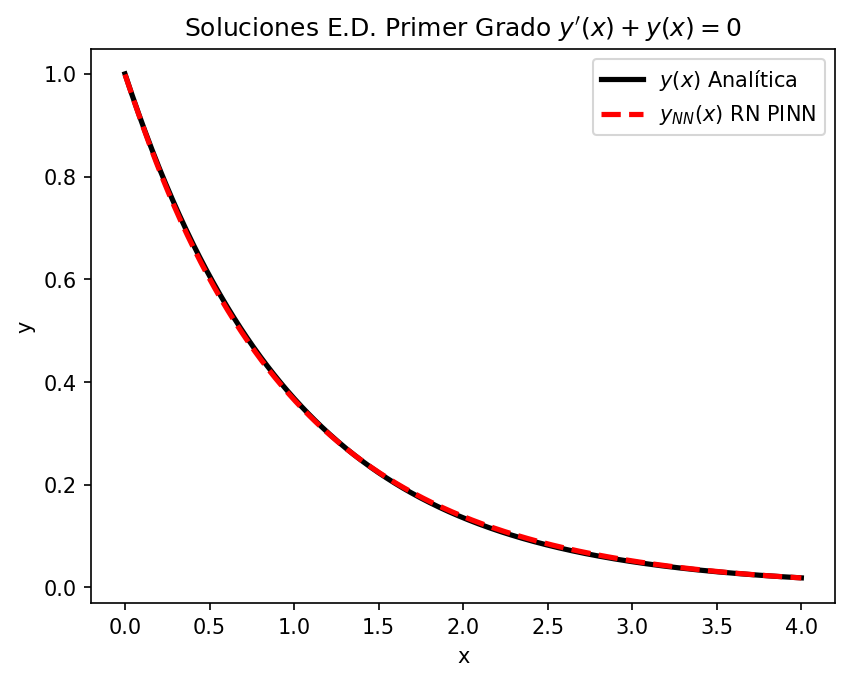

In [8]:
# Visualización de los resultados de la red
# Evaluamos la red en puntos adicionales para observar su precisión
n = 500  # Número de puntos en el dominio para graficar
x = np.linspace(0, 4, n)  # Generamos puntos entre 0 y 4
y_exact = tf.exp(-x)  # Solución exacta en los puntos generados
y_NN = model.predict(x)  # Predicción de la red en esos puntos

# Gráfica de la solución exacta y la predicción de la red PINN
plt.rcParams['figure.dpi'] = 150
plt.plot(x, y_exact, color="black", linestyle='solid', linewidth=2.5, label="$y(x)$ Analítica")
plt.plot(x, y_NN, color="red", linestyle='dashed', linewidth=2.5, label="$y_{NN}(x)$ RN PINN")

plt.legend()
plt.title("Soluciones E.D. Primer Grado $y'(x) + y(x) = 0$")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
